# Exploring Metabolic Models

**Requirements**

- Escher maps module (https://escher.github.io/#/)
- Activated version of the Gurobi solver (https://www.gurobi.com/)

Import COBRApy and the iML1515 E. coli metabolic network reconstruction

In [74]:
import cobra

In [75]:
model = cobra.io.read_sbml_model('./iML1515.xml')

Explore properties of the model structure. You can try tab completing "model." to see the list of model attributes.

In [76]:
model

Name,iML1515
Memory address,0x02f73d1d0a90
Number of metabolites,1877
Number of reactions,2712
Number of groups,0
Objective expression,1.0*BIOMASS_Ec_iML1515_core_75p37M - 1.0*BIOMASS_Ec_iML1515_core_75p37M_reverse_35685
Compartments,"cytosol, extracellular space, periplasm"


You can explore model variables by index

In [77]:
ind_test = 0

print(model.reactions[ind_test].id)
print(model.reactions[ind_test].reaction)
print(model.reactions[ind_test].lower_bound)
print(model.reactions[ind_test].upper_bound)

CYTDK2
cytd_c + gtp_c --> cmp_c + gdp_c + h_c
0.0
1000.0


Or you can use 'getter' functions to get attributes for specific reactions of interest

In [78]:
print(model.reactions.get_by_id("EX_glc__D_e").lower_bound)

-10.0


You can also change values for constraints.

In [70]:
model.reactions.get_by_id("EX_glc__D_e").lower_bound = -9

## Adding reactions

Now let's try adding a reaction to our model

In [79]:
from cobra import Model, Reaction, Metabolite

reaction = Reaction('R_3OAS140')
reaction.name = '3 oxoacyl acyl carrier protein synthase n C140 '
reaction.subsystem = 'Cell Envelope Biosynthesis'
reaction.lower_bound = 0.  # This is the default
reaction.upper_bound = 1000.  # This is the default

We need to create metabolites as well. If we were using an existing model, we could use Model.get_by_id to get the appropriate Metabolite objects instead.

In [80]:
ACP_c = Metabolite(
    'ACP_c',
    formula='C11H21N2O7PRS',
    name='acyl-carrier-protein',
    compartment='c')
omrsACP_c = Metabolite(
    'M3omrsACP_c',
    formula='C25H45N2O9PRS',
    name='3-Oxotetradecanoyl-acyl-carrier-protein',
    compartment='c')
co2_c = Metabolite('co2_c', formula='CO2', name='CO2', compartment='c')
malACP_c = Metabolite(
    'malACP_c',
    formula='C14H22N2O10PRS',
    name='Malonyl-acyl-carrier-protein',
    compartment='c')
h_c = Metabolite('h_c', formula='H', name='H', compartment='c')
ddcaACP_c = Metabolite(
    'ddcaACP_c',
    formula='C23H43N2O8PRS',
    name='Dodecanoyl-ACP-n-C120ACP',
    compartment='c')

In [81]:
reaction.add_metabolites({
    malACP_c: -1.0,
    h_c: -1.0,
    ddcaACP_c: -1.0,
    co2_c: 1.0,
    ACP_c: 1.0,
    omrsACP_c: 1.0
})

reaction.reaction  # This gives a string representation of the reaction

'ddcaACP_c + h_c + malACP_c --> ACP_c + M3omrsACP_c + co2_c'

Add a Gene-Protein-Reaction rule

In [82]:
reaction.gene_reaction_rule = '( STM2378 or STM1197 )'
reaction.genes

frozenset({<Gene STM1197 at 0x2f74a481ee0>, <Gene STM2378 at 0x2f74a481ca0>})

Finally we can add the reaction

In [83]:
model.add_reactions([reaction]) 

# Flux Balance Analysis

This model comes set with physiologically realistic constraints - so we can go ahead and try running Flux Balance Analysis on the model using the optimize() function

In [84]:
print(model.objective)
solution = model.optimize()

Maximize
1.0*BIOMASS_Ec_iML1515_core_75p37M - 1.0*BIOMASS_Ec_iML1515_core_75p37M_reverse_35685


The Model.optimize() function will return a Solution object. A solution object has several attributes:

- objective_value: the objective value

- status: the status from the linear programming solver

- fluxes: a pandas series with flux indexed by reaction identifier. The flux for a reaction variable is the difference of the primal values for the forward and reverse reaction variables.

- shadow_prices: a pandas series with shadow price indexed by the metabolite identifier.

The reaction fluxes and objective value are typically what we are interested in for FBA.

The shadow prices, which are how much the objective value can change from an injection of a particular metabolite (i.e. relaxation of a constraint) can be helpful for diagnosing a metabolic model that cannot grow. Non-zero shadow prices can indicate a limiting nutrient.

For now, let's print the objective value, which is a growth rate since the objective is the biomass reaction

In [85]:
solution.objective_value

0.876997214426972

We can see a summary of the model settings, including the objective, FBA objective value, any exchanged metabolites, and metabolite contribution to carbon flux using the summary function

In [86]:
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ca2_e,EX_ca2_e,0.004565,0,0.00%
cl_e,EX_cl_e,0.004565,0,0.00%
cobalt2_e,EX_cobalt2_e,2.192E-05,0,0.00%
cu2_e,EX_cu2_e,0.0006218,0,0.00%
fe2_e,EX_fe2_e,0.01409,0,0.00%
glc__D_e,EX_glc__D_e,10,6,100.00%
k_e,EX_k_e,0.1712,0,0.00%
mg2_e,EX_mg2_e,0.007608,0,0.00%
mn2_e,EX_mn2_e,0.000606,0,0.00%
mobd_e,EX_mobd_e,6.139E-06,0,0.00%


We can also look at the fluxes of reactions either producing or consuming a metabolite of interest using the summary() function. This can be helpful to identify the largest contributors to turnover of a key metabolite, such as a cofactor or precursor.

In [87]:
model.metabolites.nadh_c.summary()

Percent,Flux,Reaction,Definition
14.18%,5.97,AKGDH,akg_c + coa_c + nad_c --> co2_c + nadh_c + succoa_c
0.00%,0.0001956,AMPMS2,air_c + h2o_c + nad_c --> 4ampm_c + 2.0 for_c + 3.0 h_c + nadh_c
40.63%,17.11,GAPD,g3p_c + nad_c + pi_c <=> 13dpg_c + h_c + nadh_c
0.11%,0.04754,GLYCL,gly_c + nad_c + thf_c --> co2_c + mlthf_c + nadh_c + nh4_c
0.39%,0.1662,HISTD,h2o_c + histd_c + 2.0 nad_c --> 3.0 h_c + his__L_c + 2.0 nadh_c
0.51%,0.2133,IMPD,h2o_c + imp_c + nad_c --> h_c + nadh_c + xmp_c
0.94%,0.3951,IPMD,3c2hmp_c + nad_c --> 3c4mop_c + h_c + nadh_c
16.35%,6.885,MDH,mal__L_c + nad_c <=> h_c + nadh_c + oaa_c
0.00%,0.0001956,OPHHX3,2oph_c + 2.0 atp_c + 3.0 h2o_c + nad_c --> 2ohph_c + 2.0 adp_c + 3.0 h_c + nadh_c + 2.0 pi_c
23.02%,9.69,PDH,coa_c + nad_c + pyr_c --> accoa_c + co2_c + nadh_c


Now let's try changing the model constraints and see how the results change

In [88]:
model.reactions.get_by_id("EX_o2_e").lower_bound = 0 #Changing the model to an anaerobic condition
solution2 = model.optimize()

In [89]:
solution2.objective_value #We can see that the growth rate has decreased

0.1575398169375959

We can also try to knock out a reaction or gene using the knock_out() function of a reaction object. This could also be done by setting the lower and upper bound of a reaction to 0. 

In [90]:
print('complete model: ', model.optimize())
with model:
    model.reactions.PGI.knock_out()
    print('PGI knocked out: ', model.optimize())

complete model:  <Solution 0.158 at 0x2f74a61f1c0>
PGI knocked out:  <Solution 0.136 at 0x2f74a61f340>


There are also specialized functions for knocking out every gene from the model, which is a typical performance test to compare models to experimental data.

In [91]:
from cobra.flux_analysis import (
    single_gene_deletion, single_reaction_deletion, double_gene_deletion,
    double_reaction_deletion)

single_gene_deletion(model, model.genes[:20])

,ids,growth,status
0,{b1094},0.000000,optimal
1,{b0008},0.157540,optimal
2,{b1260},0.000000,optimal
3,{b1095},0.157540,optimal
4,{b1054},0.157540,optimal
5,{b3368},0.000000,optimal
6,{b2465},0.157540,optimal
7,{b4467},0.157540,optimal
8,{b2979},0.157540,optimal
9,{b2436},0.157540,optimal


Last, other than growth, we are often interested in different metabolic objectives. The objective function can be changed by assigning Model.objective, which can be a reaction object (or just it’s name), or a dict of {Reaction: objective_coefficient}.

In [92]:
# change the objective to acetate secretion
with model:
    model.objective = "EX_ac_e"
    print(model.optimize().objective_value)

25.256


# Other Constraint-based Simulations

## Flux Variability Analysis

More involved than Flux Balance Analysis is Flux Variability Analysis, which runs a series of FBA problems, maximizing and minimizing every reaction in the model one by one. This is often used after already constraining growth rate to a high level in order to assess the uncertainty in reaction flux predictions.

Since FVA involves 2n optimizations, where n is the number of reactions in the model, this can take a substantial amount of time. So in this example we only show this for the first 10 reactions.

In [7]:
from cobra.flux_analysis import flux_variability_analysis
flux_variability_analysis(model, model.reactions[:10])

,minimum,maximum
CYTDK2,0.000000,-2.657430e-12
XPPT,0.000000,-1.443290e-12
HXPRT,0.000000,-1.111333e-12
NDPK5,-0.022948,-1.166695e-11
SHK3Dr,0.334240,3.342403e-01
NDPK6,0.000000,0.000000e+00
NDPK8,-0.022948,-8.126420e-12
DHORTS,-0.290106,-2.901063e-01
OMPDC,0.290106,2.901063e-01
PYNP2r,0.000000,2.294751e-02


Flux variability analysis can also be embedded in calls to summary methods. For instance, the expected variability in substrate consumption and product formation can be quickly found by

In [61]:
model.summary(fva=0.95)

Metabolite,Reaction,Flux,Range,C-Number,C-Flux
ca2_e,EX_ca2_e,0.00082,[0.000779; 0.00082],0,0.00%
cl_e,EX_cl_e,0.00082,[0.000779; 0.00082],0,0.00%
co2_e,EX_co2_e,0.05785,[-3.573; 3.683],1,0.10%
cobalt2_e,EX_cobalt2_e,3.938E-06,[3.742E-06; 3.938E-06],0,0.00%
cu2_e,EX_cu2_e,0.0001117,[0.0001061; 0.0001117],0,0.00%
fe2_e,EX_fe2_e,0.0013,[-0.7246; 0.01676],0,0.00%
fe3_e,EX_fe3_e,0.00123,[0.001169; 0.727],0,0.00%
glc__D_e,EX_glc__D_e,10,[9.637; 10],6,99.90%
h2o_e,EX_h2o_e,4.591,[3.048; 6.676],0,0.00%
k_e,EX_k_e,0.03075,[0.02921; 0.03075],0,0.00%


Similarly, variability in metabolite mass balances can also be checked with flux variability analysis.

In [ ]:
model.metabolites.pyr_c.summary(fva=0.95)

## Sampling

Sampling uses the model constraints to explore the convex space of steady-state flux solutions without needing to specify an objective. Sampling, like FVA, is a way to explore the uncertainty in the flux solutions.

Sampling can take quite a while to converge to an even coverage of the solution space, so here we utilize a test set.

In [93]:
from cobra.test import create_test_model
from cobra.sampling import sample

model_test = create_test_model("textbook")
s = sample(model_test, 100)
s.head()

Read LP format model from file C:\Users\dczie\AppData\Local\Temp\tmp6zkj_n9h.lp
Reading time = 0.01 seconds
: 72 rows, 190 columns, 720 nonzeros


,ACALD,ACALDt,ACKr,ACONTa,ACONTb,ACt2r,ADK1,AKGDH,AKGt2r,ALCD2x,...,RPI,SUCCt2_2,SUCCt3,SUCDi,SUCOAS,TALA,THD2,TKT1,TKT2,TPI
0,-1.944100,-0.234697,-1.634220,7.235947,7.235947,-1.634220,5.465146,4.928536,-0.006722,-1.709404,...,-1.590122,25.249585,26.252326,259.914955,-4.928536,1.534737,55.358513,1.534737,1.512464,8.359180
1,-0.148337,-0.086553,-3.347795,4.700326,4.700326,-3.347795,15.163620,2.018225,-0.146486,-0.061784,...,-3.379173,16.624926,16.967696,48.004523,-2.018225,3.362268,10.124611,3.362268,3.355470,6.265996
2,-1.489471,-0.143653,-1.005303,10.139851,10.139851,-1.005303,8.566371,4.857130,-0.034080,-1.345818,...,-1.531850,30.730172,32.040497,302.637519,-4.857130,1.525868,4.186454,1.525868,1.523463,8.236296
3,-3.907640,-1.439393,-0.265464,6.564202,6.564202,-0.265464,1.279222,0.389565,-0.043473,-2.468247,...,-3.959534,11.836373,12.441058,270.988055,-0.389565,3.952290,26.711634,3.952290,3.949377,5.974063
4,-1.915945,-0.358212,-0.696112,9.811936,9.811936,-0.696112,18.623494,0.187137,-0.242056,-1.557733,...,-3.184814,32.994230,33.623006,236.079641,-0.187137,3.173005,7.799512,3.173005,3.168256,6.169982


Sampling is a parallelizable process, and we can specify the number of processors we want to use.

In [38]:
print("One process:")
%time s = sample(model_test, 1000)
print("Two processes:")
%time s = sample(model_test, 1000, processes=2)

One process:
Read LP format model from file C:\Users\dczie\AppData\Local\Temp\tmpjkpl9tiv.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Wall time: 5.73 s
Two processes:
Read LP format model from file C:\Users\dczie\AppData\Local\Temp\tmpptjfmvf4.lp
Reading time = 0.01 seconds
: 72 rows, 190 columns, 720 nonzeros
Wall time: 6.39 s


## Production Envelopes

Production Envelopes are phase planes showing how the feasible steady-state flux space relates to the exchange of two metabolites of interest (or growth rate)

In [49]:
from cobra.flux_analysis import production_envelope

prod_env = production_envelope(
    model_test, ["EX_o2_e"], objective="EX_ac_e", carbon_sources="EX_glc__D_e")
prod_env.head()

,carbon_source,flux_minimum,carbon_yield_minimum,mass_yield_minimum,flux_maximum,carbon_yield_maximum,mass_yield_maximum,EX_o2_e
0,EX_glc__D_e,0.0,0.0,0.0,0.000000,0.000000,0.000000,-60.000000
1,EX_glc__D_e,0.0,0.0,0.0,1.578947,0.052632,0.051748,-56.842105
2,EX_glc__D_e,0.0,0.0,0.0,3.157895,0.105263,0.103496,-53.684211
3,EX_glc__D_e,0.0,0.0,0.0,4.736842,0.157895,0.155245,-50.526316
4,EX_glc__D_e,0.0,0.0,0.0,6.315789,0.210526,0.206993,-47.368421


In [50]:
%matplotlib inline

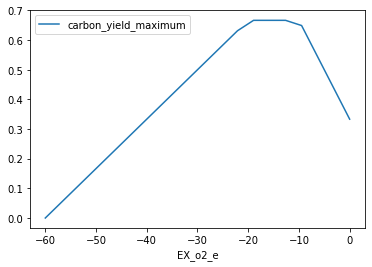

In [51]:
prod_env.plot(
    kind='line', x='EX_o2_e', y='carbon_yield_maximum');